In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from torchvision.io import read_image
from torchvision.io import ImageReadMode

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [2]:
##### 学習データ/テストデータ作成
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # 正解ラベル

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
##### モデル定義
class CNN(nn.Module):
  def __init__(self, num_classes):
    super().__init__()
    # torch.Size([32, 3, 32, 32])
    self.features = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2)
    )
    self.flatten = nn.Flatten()
    self.classifier = nn.Linear(in_features=4096, out_features=num_classes)

  def forward(self, x):
    x = self.features(x) # torch.Size([32, 256, 4, 4])
    x = self.flatten(x) # torch.Size([32, 4096])
    x = self.classifier(x)
    return x

model = CNN(len(classes))
model.to(device)

CNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (classifier): Linear(in_features=409

In [4]:
##### 損失関数、オプティマイザ
lr = 0.01

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [5]:
##### 学習
num_epochs = 30
train_losses = []
train_accs = []
test_losses = []
test_accs = []

for epoch in range(num_epochs):
  train_running_loss = 0.0
  train_running_acc = 0.0
  for imgs, labels in train_dataloader:
    imgs = imgs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()
    output = model(imgs)
    loss = criterion(output, labels)
    loss.backward()
    train_running_loss += loss.item()
    pred = torch.argmax(output, dim=1)
    train_running_acc += torch.mean(pred.eq(labels).float())
    optimizer.step()
  train_running_loss /= len(train_dataloader)
  train_running_acc /= len(train_dataloader)
  train_losses.append(train_running_loss)
  train_accs.append(train_running_acc.cpu())

  test_running_loss = 0.0
  test_running_acc = 0.0
  for imgs, labels in test_dataloader:
    imgs = imgs.to(device)
    labels = labels.to(device)
    output = model(imgs)
    loss = criterion(output, labels)
    test_running_loss += loss.item()
    pred = torch.argmax(output, dim=1)
    test_running_acc += torch.mean(pred.eq(labels).float())
  test_running_loss /= len(test_dataloader)
  test_running_acc /= len(test_dataloader)
  test_losses.append(test_running_loss)
  test_accs.append(test_running_acc.cpu())

  print(f"epoch: {epoch}, train-loss: {train_running_loss}, train-acc: {train_running_acc}, test-loss: {test_running_loss}, test-acc: {test_running_acc}")

epoch: 0, train-loss: 2.288680608274078, train-acc: 0.1358165442943573, test-loss: 2.095537584429732, test-acc: 0.23542331159114838
epoch: 1, train-loss: 1.8985290086505815, train-acc: 0.3078814744949341, test-loss: 1.652698942266714, test-acc: 0.3998602032661438
epoch: 2, train-loss: 1.5710135136974674, train-acc: 0.42692339420318604, test-loss: 1.4208869720800235, test-acc: 0.4847244322299957
epoch: 3, train-loss: 1.3782257128814361, train-acc: 0.5069977641105652, test-loss: 1.3316647351359407, test-acc: 0.5180710554122925
epoch: 4, train-loss: 1.2157492520560536, train-acc: 0.5690978765487671, test-loss: 1.1202490666803842, test-acc: 0.6022363901138306
epoch: 5, train-loss: 1.073461889076599, train-acc: 0.6231805682182312, test-loss: 1.1838323830034787, test-acc: 0.5794728398323059
epoch: 6, train-loss: 0.9596686849819874, train-acc: 0.6629078984260559, test-loss: 0.9708836204327714, test-acc: 0.6643370389938354
epoch: 7, train-loss: 0.8563779411373883, train-acc: 0.7012355923652649

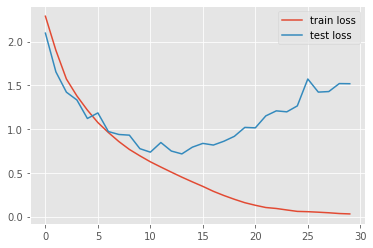

In [6]:
##### 評価: loss
plt.style.use("ggplot")
plt.plot(train_losses, label="train loss")
plt.plot(test_losses, label="test loss")
plt.legend()

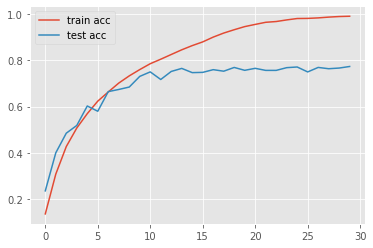

In [7]:
##### 評価: accs
plt.plot(train_accs, label="train acc")
plt.plot(test_accs, label="test acc")
plt.legend()